# UKBB Prescription Data

## Load Packages

In [ ]:
# Import packages 
import os
import pandas as pd
import numpy as np
import hail as hl
import re

import datetime
from hail.plot import show
from pprint import pprint
import scipy
import statistics as st
hl.init()
hl.plot.output_notebook()

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
import re
import pickle

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

## Import Data into Hail

In [ ]:
"""
Field names are originally from Courtney's pandas code
"""

raw_data_loc = 'gs://ukb31063/ukb31063.gp_scripts.20191008.txt'
# fs = [f"f{i}" for i in range(0, 8)]
# fields = ['eid','data_provider','issue_date','read_v2','bnf','dmd','drug_name','drug_quantity']
hl_presc = hl.import_table(raw_data_loc, no_header=False, delimiter='\t', impute=True)

drug_counts = hl_presc.group_by(hl_presc.drug_name).aggregate(counts = hl.agg.count())
drug_counts.show()

## Export Drugs with >10k, >1k, and 100 Counts

In [ ]:
# For the initial curation task, I restricted to the ~700 scripts
# that had >10,000 instances
top_drugs_10k = drug_counts.filter(drug_counts.counts > 10000)
top_drugs_10k.export('gs://gsarma/top_drugs_10k.tsv')

# Drugs that have >1000 scripts likely cover what we 
# might want for future studies. An efficient way to bootstrap
# from the manually curated list of ~700 to the ~3500 in this
# larger list is a significant step. 
top_drugs_1k = drug_counts.filter(drug_counts.counts > 1000)
top_drugs_1k.export('gs://gsarma/top_drugs_1k.tsv')

# Pre-curation Steps

In [375]:
"""
This is the first step of the curation process, simply split on the first non-word character
(most often a whitespace), and extract the first token. This is typically the generic name, 
but each drug needs to be looked at and potentially corrected.  

I found that this part was faster to do in pandas than with Hail, largely because of the
availability of questions on StackExchange. 
"""

def fill_possible_generic(dfname):
    """
    Use first token in raw prescription string as candidate generic name
    """
    dfname = dfname.drop(0) #The first row is the empty string, i.e. there are a large number of empty prescriptions
    expr = '(^[\w]+)'
    newdf = pd.DataFrame()
    newdf['original_prescription'] = dfname['drug_name']
    newdf['possible_generic'] = newdf['original_prescription'].str.extract(expr, expand=True)
    newdf['possible_generic'] = newdf['possible_generic'].str.lower()
    
    return newdf

def fill_delivery_system(dfname):
    """
    Extract delivery system for drug such as tablet, capsule, inhaler, etc. 
    """
    med_type = []
    for values in dfname['original_prescription']:
        # PO
        if re.search('tab|tabs|tablet', values, re.IGNORECASE):
            med_type.append('Tablet')
        elif re.search('cap|caps|capsule', values, re.IGNORECASE): 
            med_type.append('Capsule')    
        elif re.search('oral liquid', values, re.IGNORECASE):
            med_type.append('Oral Liquid')
        elif re.search('oral suspension', values, re.IGNORECASE): 
            med_type.append('Oral Suspension')
        elif re.search('oral powder', values, re.IGNORECASE): 
            med_type.append('Oral Powder')
        elif re.search('solution', values, re.IGNORECASE): 
            med_type.append('Solution')
        elif re.search('sublingual spray', values, re.IGNORECASE): 
            med_type.append('Sublingual Spray')
        elif re.search('oral liquid|liquid peppermint|oral lyophilisates', values, re.IGNORECASE):
            med_type.append('Oral Liquid')
        elif re.search('ispaghula husk', values, re.IGNORECASE): 
            med_type.append('Food Supplement')

        # Nasal
        elif re.search('nasal cream', values, re.IGNORECASE): 
            med_type.append('Nasal Cream')
        elif re.search('nasal spray', values, re.IGNORECASE): 
            med_type.append('Nasal Spray')

        # Ear
        elif re.search('ear spray', values, re.IGNORECASE): 
            med_type.append('Ear Spray')
        elif re.search('ear drops', values, re.IGNORECASE): 
            med_type.append('Ear Drops')

        # Eye
        elif re.search('eye ointment', values, re.IGNORECASE): 
            med_type.append('Eye Ointment')
        elif re.search('eye drops', values, re.IGNORECASE): 
            med_type.append('Eye Drops')

        # Topical 
        elif re.search('gel', values, re.IGNORECASE): 
            med_type.append('Gel')
        elif re.search('ointment', values, re.IGNORECASE): 
            med_type.append('Ointment')
        elif re.search('cream|emollient', values, re.IGNORECASE): 
            med_type.append('Cream')
        elif re.search('shampoo', values, re.IGNORECASE): 
            med_type.append('Shampoo')
        elif re.search('lotion|shower emollient', values, re.IGNORECASE): 
            med_type.append('Lotion')
        elif re.search('scalp application', values, re.IGNORECASE): 
            med_type.append('Cream')
        elif re.search('medicated nail lacquer', values, re.IGNORECASE): 
            med_type.append('Medicated Nail Lacquer')
        elif re.search('patch', values, re.IGNORECASE):
            med_type.append('Patch')
        elif re.search('vaginal moisturiser', values, re.IGNORECASE): 
            med_type.append('Vaginal Moisturizer')

        # Diagnostic 
        elif re.search('testing strip', values, re.IGNORECASE): 
            med_type.append('Testing Strip')

        # Other
        elif re.search('inhaler|Evohaler|Accuhaler|Turbohaler|inhalation', values, re.IGNORECASE): 
            med_type.append('Inhaler')
        elif re.search('disc', values, re.IGNORECASE): 
            med_type.append('Disc Inhaler')
        elif re.search('volumatic|AeroChamber', values, re.IGNORECASE): 
            med_type.append('Inhaler Assist Device')
        elif re.search('pessary|pessaries', values, re.IGNORECASE): 
            med_type.append('Pessary')
        elif re.search('needle|injection', values, re.IGNORECASE): 
            med_type.append('Injection')
        elif re.search('vaccine', values, re.IGNORECASE): 
            med_type.append('Vaccine')
        elif re.search('lancet', values, re.IGNORECASE): 
            med_type.append('Lancet')

        else:
            med_type.append('NA')
            
    dfname['Delivery_System'] = med_type
    
    return dfname

def fill_dosages(dfname):
    """
    Extract dosages. Note that fill_delivery_system must be run BEFORE
    fill_dosages can be run, as the dosage patterns are 
    dependent on the type of delivery system.  
    """
    dosages = []
    single_dose_pat = "[0-9]+(\.)*[0-9]*(([a-zA-z]*)|(\%)*)"
    cream_pat = "[0-9]+(\.)*[0-9]*%"

    for values in dfname.iterrows():
        dtype = values[1]['Delivery_System']
        presc = values[1]['original_prescription']
        if (dtype == 'Tablet') | (dtype == 'Capsule') | (dtype == 'Eye Drops'):
            if re.search(single_dose_pat, presc):
                dosages.append(re.search(single_dose_pat, presc).group(0))
            else:
                dosages.append('NA')
        elif (dtype == 'Cream'):
            if re.search(cream_pat, presc):
                dosages.append(re.search(cream_pat, presc).group(0))
            else:
                dosages.append('NA')
        else:
            dosages.append('NA')
    
    dfname['Dosage'] = dosages
    
    return dfname
    
def pre_curation(dfname):
    """
    Prepare the UKBB GP data for curation by filling in possible
    generic names, delivery systems, and dosages.  
    """
    return fill_dosages(fill_delivery_system(fill_possible_generic(dfname)))

In [257]:
td10k = pd.read_csv('/Users/gsarma/Dropbox/Broad/UKBB/top_drugs_10k.tsv', sep='\t')
td1k = pd.read_csv('/Users/gsarma/Dropbox/Broad/UKBB/top_drugs_1k.tsv', sep='\t')
curated = pd.read_csv('/Users/gsarma/git/UKBB_prescriptions/UKBB_prescriptions_v2.csv', sep=',')

td1ka = pre_curation(td1k)

In [379]:
pre_curation(td10k)

,original_prescription,possible_generic,Delivery_System,Dosage
1,ADALAT LA tablets 30mg [BAYER],adalat,Tablet,30mg
2,ALENDRONIC ACID (AS SODIUM SALT) tabs 70mg,alendronic,Tablet,70mg
3,AMITRIPTYLINE HCl tabs 10mg,amitriptyline,Tablet,10mg
4,AMLODIPINE tabs 10mg,amlodipine,Tablet,10mg
5,AMLODIPINE tabs 5mg,amlodipine,Tablet,5mg
6,AMOXICILLIN caps 500mg,amoxicillin,Capsule,500mg
7,ASACOL MR tablets 400mg [PROCT&GAMB],asacol,Tablet,400mg
8,ASPIRIN DISPERSIBLE TABLETS 75MG,aspirin,Tablet,75MG
9,ASPIRIN disp tab 75mg,aspirin,Tablet,75mg
10,ASPIRIN ec tab 75mg,aspirin,Tablet,75mg


# Bootstrapping From Curated Entries

In [4]:
top_drugs = pd.read_csv('/Users/gsarma/Dropbox/Broad/UKBB/top_drugs_1k.tsv', sep='\t')
top_drugs = top_drugs.drop(0)
top_drugs = top_drugs.sort_values(by='counts', ascending=False)
last = len(top_drugs.index) - 1

In [5]:
all_dist = []
for n in range(round(last/2)):
    base = top_drugs.iloc[last - n].drug_name # Start at the end and work to the half-way point
    temp_dist = []
    for k in range(round(last/2)):
        l_dist = fuzz.token_sort_ratio(base, top_drugs.iloc[k].drug_name)
        # Start at the *beginning* and work to the half-way point
        temp_dist.append(l_dist)
    m = max(temp_dist)
    # First find all the indices where a maximum happens and take the minimum
    all_dist.append(min([i for i, j in enumerate(temp_dist) if j == m]))

(array([10., 10., 16., 16., 22., 20., 24., 25., 21., 40., 28., 33., 39.,
        20., 23., 27., 32., 18., 28., 21., 14., 26., 20., 12., 22., 12.,
        17., 14., 13., 19., 25., 18., 23.,  8., 19., 20., 25., 16., 15.,
        10., 25., 14., 18., 27., 13., 18., 10., 14., 18., 14., 15., 10.,
        18.,  9., 20., 16.,  9., 19., 15., 12., 13., 15., 20., 20., 15.,
        27., 11., 10., 10., 12.,  7., 13., 14., 15., 17., 14., 22., 21.,
        16., 11., 13., 14., 21., 14., 13., 12., 21., 14., 16., 25., 14.,
        35., 13., 17., 23., 11.,  9., 24., 24., 21.]),
 array([   0.  ,   17.87,   35.74,   53.61,   71.48,   89.35,  107.22,
         125.09,  142.96,  160.83,  178.7 ,  196.57,  214.44,  232.31,
         250.18,  268.05,  285.92,  303.79,  321.66,  339.53,  357.4 ,
         375.27,  393.14,  411.01,  428.88,  446.75,  464.62,  482.49,
         500.36,  518.23,  536.1 ,  553.97,  571.84,  589.71,  607.58,
         625.45,  643.32,  661.19,  679.06,  696.93,  714.8 ,  732.67,
        

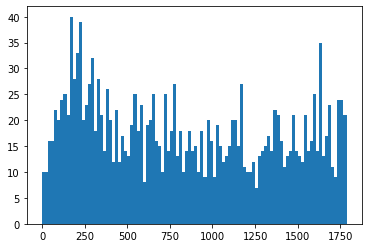

In [6]:
plt.hist(all_dist, bins=100)

In [41]:
check_quality = []
for n in range(0,1700,100):
    check_quality.append([top_drugs.iloc[last-n].drug_name, top_drugs.iloc[all_dist[n]].drug_name])

In [42]:
qc_df = pd.DataFrame(check_quality)
qc_df

,0,1
0,CITALOPRAM TABLETS 40MG,Citalopram 40mg tablets
1,HUMALOG MIX 25 injection 25:75; 100 units/ml [...,insulin glargine injection 100 units/ml
2,CANDESARTAN CILEXETIL TABLETS 8MG,Candesartan Cilexetil Tablets 8 mg
3,Dantrolene 25mg capsules,Dosulepin 25mg capsules
4,ROFECOXIB tabs 25mg,Rofecoxib 25mg tablets
5,Lotriderm cream (Merck Sharp & Dohme Ltd),Elocon 0.1% cream (Merck Sharp & Dohme Ltd)
6,CLOBETASONE BUTYRATE crm 0.05%,Clobetasone 0.05% cream
7,GlucoGel 40% gel original (BBI Healthcare Ltd),Carbomer 0.2% eye gel (Blumont Healthcare Ltd)
8,Bricanyl 250micrograms/dose inhaler (AstraZene...,Bricanyl 500micrograms/dose Turbohaler (AstraZ...
9,Propranolol Hydrochloride TABS 40MG,PROPRANOLOL tabs 40mg


In [388]:
def find_best_match(raw_script, reference):
    """
    Find the best match for a prescription string starting
    from a curated reference list.  
    TODO: option to use either generic name or full prescription string
    """
    all_dist = []
    num_ref = len(reference)-1
    token = raw_script.split(" ", 1)
    for k in range(num_ref):
        l_dist = fuzz.token_sort_ratio(raw_script, reference.iloc[k]['Generic_Name'])
        all_dist.append(l_dist)
    m = max(all_dist)
    # First find all the indices where a maximum happens and take the minimum
    index =  min([i for i, j in enumerate(all_dist) if j == m])
    return [reference.iloc[index]['Generic_Name'], reference.iloc[index]['Drug_Category_and_Indication']]

def bootstrap_curation(new_df, reference):
    """
    Take in an uncurated list of prescriptions and bootstrap 
    """
    candidate_generic = []
    candidate_category = []
    for values in new_df['possible_generic']:
        best_match = find_best_match(values, curated)
        candidate_generic.append(best_match[0])
        candidate_category.append(best_match[1])
    
    return [candidate_generic, candidate_category]

In [383]:
print(bootstrap_curation.__doc__)


    Take in an uncurated list of prescriptions and bootstrap 
    


In [393]:
short_df = td1ka.sample(n=20)
new_columns = bootstrap_curation(short_df, curated)
short_df['possible_generic'] = new_columns[0]
short_df['Drug_Category_and_Indication'] = new_columns[1]

In [394]:
short_df

,original_prescription,possible_generic,Delivery_System,Dosage,Drug_Category_and_Indication
1500,Gaviscon Advance Mint chewable tablets (Reckit...,alverine,Tablet,NA,antispasmodic
3047,Sodium cromoglicate 4% nasal spray,oilatum,Nasal Spray,NA,emollient
1637,Humalog Mix50 100units/ml suspension for injec...,sotalol,Injection,NA,"anti-arrhythmic,non-selective beta-blocker,bet..."
1452,Fultium-D3 800unit capsules (Internis Pharmace...,oilatum,Capsule,3,emollient
2930,Salbutamol 100micrograms/dose breath actuated ...,albuterol,Inhaler,NA,"beta2-agonist,bronchodilator,asthma"
246,Aspirin Dispersible TABS 75MG,aspirin,Tablet,75MG,"NSAID,non-steroidal anti-inflammatory drug"
181,Amitriptyline Hydrochloride TABS 25MG,amitriptyline,Tablet,25MG,"tricyclic antidepressant,antidepressant"
304,BD Micro-Fine Ultra hypodermic insulin needles...,bisacodyl,Injection,NA,"stimulant laxative,laxative"
1898,LOTRIDERM cream [DOMINION],loperamide,Cream,NA,"opioid,anti-diarrheal agent"
552,CODEINE PHOSPHATE tabs 15mg,codeine,Tablet,15mg,opioid analgesic


# Some Basic Data Exploration

No handles with labels found to put in legend.


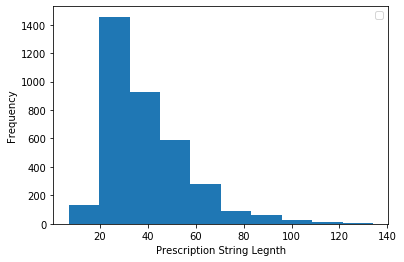

In [56]:
plt.hist(top_drugs.drug_name.str.len())
plt.xlabel("Prescription String Legnth")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [372]:
td1ka

,original_prescription,possible_generic,Delivery_System,Dosage
1,ACTONEL ONCE A WEEK tablets 35mg [PROCT&GAMB],actonel,Tablet,35mg
2,ACTRAPID PENFILL 100 units/ml [NOVO],actrapid,NA,NA
3,ACTRAPID injection 100 units/ml [NOVO],actrapid,Injection,NA
4,ADALAT LA tablets 30mg [BAYER],adalat,Tablet,30mg
5,ADALAT LA tablets 60mg [BAYER],adalat,Tablet,60mg
6,ADALAT LA tabs 30mg,adalat,Tablet,30mg
7,ADCAL -D3 LEMON chewable tab,adcal,Tablet,3
8,ADCAL -D3 chewable tab,adcal,Tablet,3
9,ADCAL -D3 chewable tab 1.5 gram + 10 microgram,adcal,Tablet,3
10,ADIZEM SR capsules 120mg [NAPPPHARM],adizem,Capsule,120mg
